In [1]:
import os
import random
import logging
import h5py
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# funky librairies for segmentation
import segmentation_models_3D as sm
from patchify import patchify, unpatchify

Segmentation Models: using `tf.keras` framework.


In [2]:
PATH_DATASET='./challenge_dataset/'
CENTER_CUBE_ONLY = False # False train on all data (split volume in 9 cubes), True train only on a (64,64,64) cube around the aneurysm = less data
TEST_SIZE = 0.2 # % of test samples from the full dataset
VAL_SPLIT = 0.2 # % of training samples kept for the validation metrics
CROP = 64

In [3]:
# get file names
file_names = os.listdir(PATH_DATASET)
N = len(file_names)
print(f'{N} samples in dataset.')

# open all .h5 files, split inputs and target masks, store all in np.arrays
raw_data = []
labels = []
names = []

for file_name in tqdm(file_names):
    f = h5py.File(f'{PATH_DATASET}/{file_name}', 'r')

    X, Y = np.array(f['raw']), np.array(f['label'])

    if CENTER_CUBE_ONLY: # only keep the center cube (over 9 candidates)
        X = X[:,CROP:2*CROP,CROP:2*CROP]
        Y = Y[:,CROP:2*CROP,CROP:2*CROP]

        raw_data.append(X)
        labels.append(Y)
        names.append(file_name)

    else: # keep all = more data
        X_patches = patchify(X, (64, 64, 64), step=64)  # Step=64 for 64 patches means no overlap
        X_patches_resh = np.reshape(X_patches, (-1, X_patches.shape[3], X_patches.shape[4], X_patches.shape[5]))
        Y_patches = patchify(Y, (64, 64, 64), step=64)  # Step=64 for 64 patches means no overlap
        Y_patches_resh = np.reshape(Y_patches, (-1, Y_patches.shape[3], Y_patches.shape[4], Y_patches.shape[5]))
        raw_data.append(X_patches_resh)
        labels.append(Y_patches_resh)
        names.append(file_name)

# convert to arrays for patchify
raw_data = np.array(raw_data)
labels = np.array(labels)

if not CENTER_CUBE_ONLY: # only keep the center cube (over 9 candidates)
    raw_data = np.reshape(raw_data, (-1, raw_data.shape[2], raw_data.shape[3], raw_data.shape[4]))
    labels = np.reshape(labels, (-1, labels.shape[2], labels.shape[3], labels.shape[4]))

# check shapes
print(raw_data.shape)
print(labels.shape)

103 samples in dataset.


100%|██████████| 103/103 [00:04<00:00, 20.91it/s]


(927, 64, 64, 64)
(927, 64, 64, 64)


In [99]:
data_gen_params = dict(
            validation_split=VAL_SPLIT,
            rotation_range=180,
            width_shift_range=0.3,
            height_shift_range=0.3,
            zoom_range=0.5,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='nearest',
            data_format='channels_first'
            # shear_range=45, # in degrees counterclockwise
        )

data_gen = ImageDataGenerator(**data_gen_params)

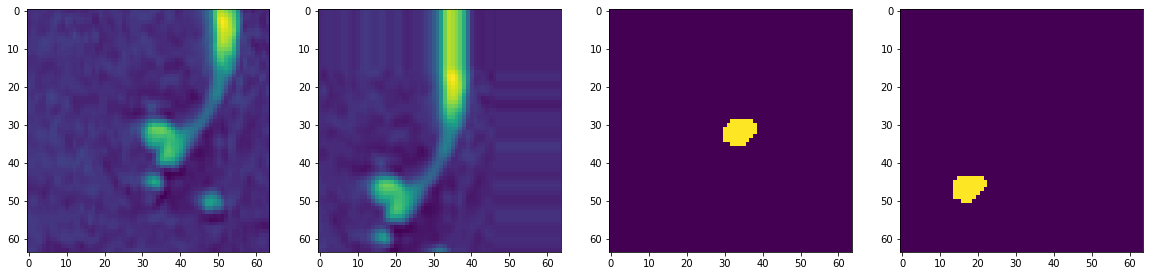

In [111]:
BATCH_SIZE = 2
SEED = 1234
ID = 4

IMG_SHAPE = (64, 64, 64)
SLICE = 32

img = raw_data[ID]
lbl = labels[ID]

transform = data_gen.get_random_transform(img_shape=IMG_SHAPE)
img_augmented = data_gen.apply_transform(img, transform)
lbl_augmented = data_gen.apply_transform(lbl, transform)

image = img[SLICE]
image_processed = img_augmented[SLICE]
lbl = lbl[SLICE]
lbl_augmented = lbl_augmented[SLICE]

plt.figure(figsize=(20, 10))
plt.subplot(141)
plt.imshow(image)
plt.subplot(142)
plt.imshow(image_processed)
plt.subplot(143)
plt.imshow(lbl)
plt.subplot(144)
plt.imshow(lbl_augmented)
plt.show()